# Nearest Neighbors

When exploring a large set of documents (such as Wikipedia, news articles, StackOverflow, etc.) it can be useful for the system to give the user a list of related material. This is also known as the **document retrieval task**.

Document Retrieval trasks require that we:
1. Decide on some convention of similarity
2. Find the documents that are most similar 

In this notebook, we:
* Gain intuition for different notions of _similarity_ 
* Explore the representation tradeoffs between representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics

As usual we need to first import the Python packages that we will need.

In [4]:
import turicreate
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Part 1. Load Wikipedia dataset

We will be using a dataset of Wikipedia pages that we used in the Machine Learning Foundations course (/ml-foundations). Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article in lowercase.

In [5]:
wiki = turicreate.SFrame('../data/people_wiki.sframe')

In [6]:
wiki

URI,name,text
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


### Extract word count vectors

In [10]:
# Use built-in text_analytics from turicreate to create a word count column containing a dictionary
wiki['word_count'] = turicreate.text_analytics.count_words(wiki['text'])

In [8]:
wiki

URI,name,text,word_count
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'melbourne': 1.0,'parade': 1.0, ..."
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'time': 1.0, 'each':1.0, 'hour': 1.0, ..."
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'society': 1.0,'hamilton': 1.0, 'to': ..."
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"{'kurdlawitzpreis': 1.0,'awarded': 1.0, '2004': ..."
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"{'curtis': 1.0, '2007':1.0, 'cent': 1.0, ..."
<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...,"{'asses': 1.0, 'sic':1.0, 'toilets': 1.0, ..."
<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...,"{'streamz': 1.0,'including': 1.0, ..."
<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...,"{'concordia': 1.0,'creative': 1.0, ..."
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"{'heavies': 1.0, 'new':1.0, 'brand': 1.0, ..."
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"{'2002': 1.0, 'harvard':1.0, 'twentieth': 1.0, ..."


## Part 2. Find nearest neighbors with Bag of Words representation


As an example we will find the Nearest Neighbors of the Barack Obama wikipedia page, using a `word_counts` vector to represent every article, and **Euclidean distance** as our similarity metric.

Turi create conveniently implements nearest neighbor search for us.

In [16]:
label = 'name'  # a query datapoints identifier
features = ['word_count']
method = 'brute_force'
distance = 'euclidean'

model = turicreate.nearest_neighbors.create(wiki, label=label, features=features,
                                            method=method, distance=distance)

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

We can look at the top 10 nearest neighbors with the following code:

In [17]:
# Call the query method on our nearest neighbors model to find 10 nearest neighbors

model.query(wiki[wiki['name']=='Barack Obama'], label='name', k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 13.418ms     |

| Done         |         | 100         | 142.719ms    |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
Barack Obama,Barack Obama,0.0,1
Barack Obama,Joe Biden,33.075670817082454,2
Barack Obama,George W. Bush,34.39476704383968,3
Barack Obama,Lawrence Summers,36.15245496505044,4
Barack Obama,Mitt Romney,36.16628264005025,5
Barack Obama,Francisco Barrio,36.3318042491699,6
Barack Obama,Walter Mondale,36.40054944640259,7
Barack Obama,Wynn Normington Hugh-Jones ...,36.49657518178932,8
Barack Obama,Don Bonker,36.6333181680284,9
Barack Obama,Andy Anstett,36.959437225152655,10


Even though the 10 people are politicians, only the first five of them have actual strong connections with Obama (besides than the fact that they are politicians).

Nearest neighbors with raw word counts may miss finer and important details in terms of real similarity.
To demostrate, let us find out why Francisco Barrio is considered a close neighbor of Obama.  

To do this, if we take look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages, most of them are unimportant stop words.

In [18]:
'''
Get a table of the most frequent words in the given person's wikipedia page name, using word count column
'''
def top_words(name):
    row = wiki[wiki['name'] == name]
    word_count_table = row[['word_count']].stack('word_count', new_column_name=['word','count'])
    return word_count_table.sort('count', ascending=False)

In [19]:
obama_words = top_words('Barack Obama')
obama_words

word,count
the,40.0
in,30.0
and,21.0
of,18.0
to,14.0
his,11.0
obama,9.0
act,8.0
a,7.0
he,7.0


In [20]:
barrio_words = top_words('Francisco Barrio')
barrio_words

word,count
the,36.0
of,24.0
and,18.0
in,17.0
he,10.0
to,9.0
chihuahua,7.0
governor,6.0
a,6.0
as,5.0


In [23]:
# Perform a JOIN operation on both dataframes of the most frequent words in barack and francisco's pages.

combined_words = obama_words.join(barrio_words, on='word')  # extract the rows from both tables corresponding to common words
combined_words = combined_words.rename({'count':'Obama', 'count.1':'Barrio'})
combined_words

word,Obama,Barrio
the,40.0,36.0
in,30.0,17.0
and,21.0,18.0
of,18.0,24.0
to,14.0,9.0
his,11.0,5.0
a,7.0,6.0
he,7.0,10.0
as,6.0,5.0
was,5.0,4.0


**Quiz Question**. From the joined table, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

`A = 56066`

In [31]:
# Extract 5 most common obama words from the combined dataframe
combined_words.sort('Obama', ascending=False)
common_words = combined_words['word'][:5]
common_words = set(common_words)


# For every word count vector of the dataset, check if all 5 of the common words are present
def has_top_words(word_count_vector):
    unique_words = set(word_count_vector.keys())    
    return common_words.issubset(unique_words)


wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

print(sum(wiki['has_top_words']))

56066


**Quiz Question**. Measure the pairwise distance between the Wikipedia pages of 
- Barack Obama, 
- George W. Bush
- Joe Biden. 

Which pair is closest?

Hints: 
* To compute the Euclidean distance between two dictionaries, use `turicreate.toolkits.distances.euclidean`. Refer to [this link](https://apple.github.io/turicreate/docs/api/generated/turicreate.toolkits.distances.euclidean.html) for usage.
* When using Boolean filter in SFrame/SArray, take the index 0 to access the first match. (Round your answer to three decimal places.)

In [54]:
# toolkits.distances.euclidean computes the euclidean distance between two dictionaries or two lists

obama = wiki[wiki['name'] == 'Barack Obama'][0]
bush = wiki[wiki['name'] == 'George W. Bush'][0]
biden = wiki[wiki['name'] == 'Joe Biden'][0]


obama_bush = turicreate.toolkits.distances.euclidean(obama['word_count'], bush['word_count'])
bush_biden = turicreate.toolkits.distances.euclidean(bush['word_count'], biden['word_count'])
obama_biden = turicreate.toolkits.distances.euclidean(obama['word_count'], biden['word_count'])


print(obama_bush)
print(bush_biden)    # closest winner
print(obama_biden)

34.39476704383968
32.7566787083184
33.075670817082454


**Quiz Question**. Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page.

`A = ['the', 'in', 'of', 'and', 'to', 'he', 'as', 'president', 'his', 'a']`

In [55]:
bush_words = top_words('George W. Bush')

obama_bush_words = obama_words.join(bush_words, on='word')
obama_bush_words = obama_bush_words.rename({'count':'Obama', 'count.1':'Bush'})
obama_bush_words

word,Obama,Bush
the,40.0,39.0
in,30.0,22.0
of,18.0,14.0
and,21.0,14.0
to,14.0,11.0
he,7.0,8.0
as,6.0,6.0
president,4.0,6.0
his,11.0,6.0
a,7.0,6.0


In [40]:
# Extract 10 most common words in Obama from the bush-obama words
obama_bush_words.sort('Obama', ascending=False)
results = obama_bush_words['word'][:10]
results

dtype: str
Rows: 10
['the', 'in', 'of', 'and', 'to', 'he', 'as', 'president', 'his', 'a']

## Part 3. Find NN with TF-IDF representation

Nearest neighbors using a normal Bag of Words that includes very common words in English is recommending plausible results (we got all politicians), but sometimes for the wrong reasons (they aren't related for any other reason). 

To retrieve articles that are more relevant, we can focus more on **rare words** that are important for a given article. **TF-IDF** (term frequency – inverse document frequency) is a feature representation that penalizes words that are too common globally and emphasizes locally common words.

Turi Create's conveniently implements TF-IDF. We thus repeat the search for the 10 nearest neighbors of Barack Obama:

In [41]:
# Use text_analytics built in tf_idf method to obtain a column of the tf-idf vector 

wiki['tf_idf'] = turicreate.text_analytics.tf_idf(wiki['word_count'])

In [42]:
# Create a new model that bases euclidean distance on the tf-idf vector
model_tf_idf = turicreate.nearest_neighbors.create(wiki, label='name', features=['tf_idf'],
                                                   method='brute_force', distance='euclidean')

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

In [43]:
model_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 17.099ms     |

| Done         |         | 100         | 137.68ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
Barack Obama,Barack Obama,0.0,1
Barack Obama,Phil Schiliro,106.86101369140928,2
Barack Obama,Jeff Sessions,108.87167421571078,3
Barack Obama,Jesse Lee (politician),109.04569790902957,4
Barack Obama,Samantha Power,109.10810616502708,5
Barack Obama,Bob Menendez,109.78186710530215,6
Barack Obama,Eric Stern (politician),109.9577880796839,7
Barack Obama,James A. Guest,110.4138887175989,8
Barack Obama,Roland Grossenbacher,110.47060870018984,9
Barack Obama,Tulsi Gabbard,110.6969979988001,10


Do the results make more sense?
* With a notable exception of "Roland Grossenbacher", all other 8 are American politicians and contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, and Eric Stern actually worked form Obama!

Clearly, the results are more plausible with the use of TF-IDF. 
The TF-IDF representation assigns a weight to each word's number of occurrences, determined by their "relative importance"

We now take a look at the word vector for Obama and Schilirio's pages. 

In [44]:
'''
Get a table of the most frequent words in the given person's wikipedia page name, using tf-idf vector
'''
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    word_count_table = row[['tf_idf']].stack('tf_idf', new_column_name=['word','weight'])
    return word_count_table.sort('weight', ascending=False)

In [45]:
#Sort the words in Obama's article by their TF-IDF weights;
obama_tf_idf = top_words_tf_idf('Barack Obama')
obama_tf_idf

word,weight
obama,43.2956530720749
act,27.67822262297991
iraq,17.747378587965535
control,14.887060845181308
law,14.722935761763422
ordered,14.533373950913514
military,13.115932778499415
involvement,12.784385241175055
response,12.784385241175055
democratic,12.410688697332166


In [46]:
# We do the same for Schiliro's article as well.
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
schiliro_tf_idf

word,weight
schiliro,21.972990778450388
staff,15.856441635180534
congressional,13.547087656327776
daschleschiliro,10.986495389225194
obama,9.621256238238866
waxman,9.04058524016988
president,9.033586614158258
2014from,8.683910296231149
law,7.361467880881711
consultant,6.913104037247212


In [52]:
# Using the **join** operation we learned earlier, try your hands at computing the common words 
# shared by Obama's and Schiliro's articles. 
# Sort the common words by their TF-IDF weights in Obama's document.

obama_schiliro_words = obama_tf_idf.join(schiliro_tf_idf, on="word")
obama_schiliro_words = obama_schiliro_words.rename({'weight':'Obama', 'weight.1':'Schiliro'})
obama_schiliro_words  # it is already sorted in the background

word,Obama,Schiliro
obama,43.2956530720749,9.621256238238866
law,14.722935761763422,7.361467880881711
democratic,12.410688697332166,6.205344348666083
senate,10.164288179703693,3.3880960599012306
presidential,7.386955418904825,3.6934777094524125
president,7.226869291326606,9.033586614158258
policy,6.095386282141427,3.0476931410707135
states,5.473200989631017,1.824400329877006
office,5.2481728232196465,2.6240864116098233
2011,5.107041270312876,3.4046941802085837


**Quiz Question**. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [53]:
common_words = obama_schiliro_words['word'][:5]
common_words = set(common_words)

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = unique_words = set(word_count_vector.keys())    
    
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)


# A much smaller number of wikipedia articles ahre those exact words
sum(wiki['has_top_words'])

14

By using tf-idf representation, we've eliminated noise arising from extremely common words.

## Part 4. Choosing metrics

One may wonder why Joe Biden, Obama's running mate in 2 presidential elections, did not appear in the query results of `model_tf_idf`.

In this section we will find out why. 
Let us first compute the distance between of Obama and Biden, using tf-idf.

**Quiz Question**. Compute the Euclidean distance between TF-IDF features of Obama and Biden. Recall: When using Boolean filter in SFrame/SArray, take the index 0 to access the first match. (Round your answer to three decimal places.)

`A = 123.297`

In [57]:
obama = wiki[wiki['name'] == 'Barack Obama'][0]
biden = wiki[wiki['name'] == 'Joe Biden'][0]

obama_biden_tfidf = turicreate.toolkits.distances.euclidean(obama['tf_idf'], biden['tf_idf'])
obama_biden_tfidf

123.29745600964294

The distance between Obama and Biden's wikipedia articles is larger than the distances we found for the 10 nearest neighbors, which we print again here for readability:

In [58]:
model_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 14.676ms     |

| Done         |         | 100         | 351.628ms    |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
Barack Obama,Barack Obama,0.0,1
Barack Obama,Phil Schiliro,106.86101369140928,2
Barack Obama,Jeff Sessions,108.87167421571078,3
Barack Obama,Jesse Lee (politician),109.04569790902957,4
Barack Obama,Samantha Power,109.10810616502708,5
Barack Obama,Bob Menendez,109.78186710530215,6
Barack Obama,Eric Stern (politician),109.9577880796839,7
Barack Obama,James A. Guest,110.4138887175989,8
Barack Obama,Roland Grossenbacher,110.47060870018984,9
Barack Obama,Tulsi Gabbard,110.6969979988001,10


But one may wonder, _is Biden's article that different from Obama's, more so than, say, Schiliro's_? 

It turns out that, when we compute nearest neighbors using Euclidean distances, we may unwittingly favor _shorter_ articles over longer ones. 

To demonstrate this, let us examine the document lengths for the **100 nearest neighbors** to Obama's page.

In [59]:
'''
Computes and returns the number of words of a given text in the wikipedia dataset
'''
def compute_length(row):
    return len(row['text'].split(' '))

# Create a new column for the length of the article (# of words)
wiki['length'] = wiki.apply(compute_length) 

In [64]:
# Set of the 100 nearest neighbors to Obama
nearest_neighbors_euclidean = model_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=100)

# We add the length column to this query results dataframe, joining on the reference_label and name columns
nearest_neighbors_euclidean = nearest_neighbors_euclidean.join(wiki[['name', 'length']], on={'reference_label':'name'})

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 20.26ms      |

| Done         |         | 100         | 284.34ms     |

+--------------+---------+-------------+--------------+

In [66]:
nearest_neighbors_euclidean.sort('rank')

query_label,reference_label,distance,rank,length
Barack Obama,Barack Obama,0.0,1,540
Barack Obama,Phil Schiliro,106.86101369140928,2,208
Barack Obama,Jeff Sessions,108.87167421571078,3,230
Barack Obama,Jesse Lee (politician),109.04569790902957,4,216
Barack Obama,Samantha Power,109.10810616502708,5,310
Barack Obama,Bob Menendez,109.78186710530215,6,220
Barack Obama,Eric Stern (politician),109.9577880796839,7,255
Barack Obama,James A. Guest,110.4138887175989,8,215
Barack Obama,Roland Grossenbacher,110.47060870018984,9,201
Barack Obama,Tulsi Gabbard,110.6969979988001,10,228


We will make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents for comparison.

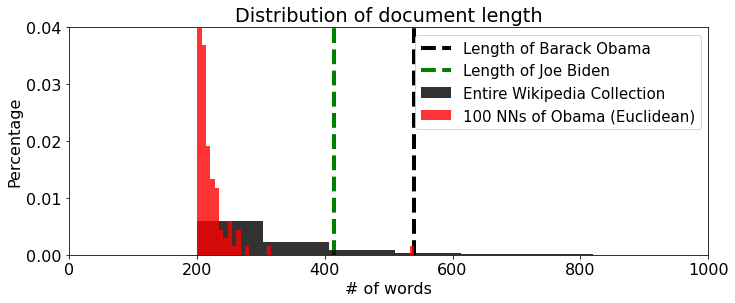

In [72]:
# NOTE: Code was provided, not of my authorship

plt.figure(figsize=(10.5,4.5))

plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia Collection', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'][0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'][0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

#### Plot observations:
Relative to the rest of our Wikipedia dataset, the nearest neighbors of Obama are extremely short! most of them being shorter than 300 words. 

We see there is a bias towards short articles. This is not appropriate for this use case: there is really no reason to favor shorter articles over longer ones. In fact, many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

_**Note**: For the sake of computation time, the dataset used in the notebook contains excerpts of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words._

## Part 5. Using Cosine Distances as our similarity metric

While the advantage of TF-IDF is that it penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them. Both metrics are proportional to word frequency. 

To remove this bias, we can turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$

Cosine distances allows us to compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances, keeping the tf-idf representation.  We then repeat the search for Obama's 100 nearest neighbors.

In [73]:
# Train a new model using tf-idf features and cosine distances

model2_tf_idf = turicreate.nearest_neighbors.create(wiki, label='name', features=['tf_idf'],
                                                    method='brute_force', distance='cosine')

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

In [74]:
# Retrieve the 100 nearest neighbors of Obama's wiki page
nearest_neighbors_cosine = model2_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=100)

# Join the results with their corresponding article length
nearest_neighbors_cosine = nearest_neighbors_cosine.join(wiki[['name', 'length']], on={'reference_label':'name'})

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 19.712ms     |

| Done         |         | 100         | 311.313ms    |

+--------------+---------+-------------+--------------+

In [75]:
# How have the query results changed with respect to using Euclidean distances?
nearest_neighbors_cosine.sort('rank')

query_label,reference_label,distance,rank,length
Barack Obama,Barack Obama,2.220446049250313e-16,1,540
Barack Obama,Joe Biden,0.703138676733575,2,414
Barack Obama,Samantha Power,0.7429819023278823,3,310
Barack Obama,Hillary Rodham Clinton,0.7583583978869677,4,580
Barack Obama,Eric Stern (politician),0.7705612276009977,5,255
Barack Obama,Robert Gibbs,0.7846775047506501,6,257
Barack Obama,Eric Holder,0.7880390729434776,7,232
Barack Obama,Jesse Lee (politician),0.7909264153663162,8,216
Barack Obama,Henry Waxman,0.7983226028934735,9,279
Barack Obama,Joe the Plumber,0.799466360041952,10,217


We now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

<Figure size 756x324 with 0 Axes>

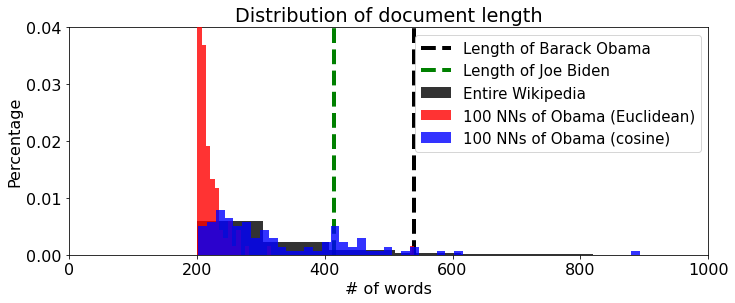

In [77]:
# Make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'][0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'][0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In conclusion, the 100 nearest neighbors using **cosine distance** provide a better sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, AWLAYS check if they produce results that make sense for your particular application.

### BXTRA: the caveat with cosine distances: tweets vs. long articles

No distance metric is ever perfect.

Because they normalize word frequency, cosine distances ignore all document lengths, which may be great in certain situations but not in others. 

For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

How similar is this tweet to Barack Obama's Wikipedia article? Let's transform the tweet into TF-IDF features, using an encoder fit to the Wikipedia dataset.  (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.)

In [ ]:
sf = turicreate.SFrame({'text': ['democratic governments control law in response to popular act']})
sf['word_count'] = turicreate.text_analytics.count_words(sf['text'])

encoder = turicreate.toolkits._feature_engineering.TFIDF(features=['word_count'], output_column_prefix='tf_idf')
encoder.fit(wiki)
sf = encoder.transform(sf)
sf

Let's look at the TF-IDF vectors for this tweet and for Barack Obama's Wikipedia entry, just to visually see their differences.

In [ ]:
tweet_tf_idf = sf[0]['tf_idf.word_count']
tweet_tf_idf

In [ ]:
obama = wiki[wiki['name'] == 'Barack Obama']
obama

Now, compute the cosine distance between the Barack Obama article and this tweet:

In [ ]:
obama_tf_idf = obama[0]['tf_idf']
turicreate.toolkits.distances.cosine(obama_tf_idf, tweet_tf_idf)

Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia 10 nearest neighbors:

In [ ]:
model2_tf_idf.query(obama, label='name', k=10)

With cosine distances, the tweet is "nearer" to Barack Obama than everyone else, except for Joe Biden!  This probably is not something we want. If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet? Ignoring article lengths completely resulted in nonsensical results. In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.